In [7]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
import cvxpy as cp

In [8]:
##Data Preperation
data=pd.read_csv("GercekZamanliTuketim-01012016-01122020 - Copy.csv", encoding ="ISO-8859-1")
data=data.apply(lambda x: x.str.replace('.',''))
data=data.apply(lambda x: x.str.replace(',','.'))
data['Tüketim Miktarý (MWh)'] = data['Tüketim Miktarý (MWh)'].astype(float)
data.insert(0,'Index',range(0,len(data)))


##Lag_168
lag_168_index=data[168:]['Index']-168
lag_168=data[data['Index'].isin(lag_168_index)]['Tüketim Miktarý (MWh)']


##Lag_48
lag_48_index=data[168:]['Index']-48
lag_48=data[data['Index'].isin(lag_48_index)]['Tüketim Miktarý (MWh)'].to_frame()
lag_48.reset_index(inplace = True)

column_names = ["Date", "Hour", "Lag_48","Lag_168"]
df = pd.DataFrame(columns = column_names)
df['Date']=data.iloc[168:,1]
df['Hour']=data.iloc[168:,2]
df['Hour']=data.iloc[168:,2]
df['Consumption']=data.iloc[168:,3]
df.reset_index(inplace = True)
df['Lag_168']=lag_168
df['Lag_48']=lag_48.loc[:,'Tüketim Miktarý (MWh)']
train_data=df.iloc[0:42216,:]
test_data=df.iloc[42216:,:]

new_train_data=train_data.pivot(index='Date', columns='Hour', values=["Lag_48","Lag_168","Consumption"])
new_test_data=test_data.pivot(index='Date', columns='Hour', values=["Lag_48","Lag_168","Consumption"])




Since I struggled with convergence problems of cvxpy package, I found a solution which is scaling the training and test data down by (1/100000).

In [9]:
#X_train = final_train_data.iloc[:,0:48]
X_train = new_train_data[['Lag_48', 'Lag_168']].values/100000
#X_test = final_test_data.iloc[:,0:48]
X_test = new_test_data[['Lag_48', 'Lag_168']].values/100000

Below, I defined functions that manually formulates our new loss metric.

In [10]:
def loss_fn(X, Y, beta):
    return cp.norm2(cp.matmul(X, beta) - Y)**2

def regularizer(beta):
    return cp.norm2(beta)

def objective_fn2(X, Y, beta, lambd, lambd2):
    return loss_fn(X, Y, beta) + lambd * regularizer(beta) + lambd2 * difference_pen(beta)

def mse(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn(X, Y, beta).value

def difference_pen(beta):
    return cp.norm1(beta[1:]-beta[:-1])

The training process that fits the optimum solution to our problem with manually defined loss is given below. First, I again scale down the "y" values by 10000 to avoid convergence problem. Second I defined the optimization problem using cvxpy package with predefined loss functions. Third, in order to determine lambda1 and lambda2 coefficients that determine the weights of our total loss metric, I searched in a log space between 10^-3 - 10^-1 on a validation set. I came up with this lambda value range by exploring wider ranges first with smaller data size due to computation complexity. I follow this procedure for each time(0,24) and eventually use the best lambda hyperparameters to train our model on our all training data. Finally, I calculated MAPe error for each observation in the test data using predictions from our final model.

In [11]:
error_list = []
for i in range(0,24):
    y_train = new_train_data.loc[:,('Consumption', str(i)+':00')].to_frame().values
    y_test = new_test_data.loc[:,('Consumption', str(i)+':00')].to_frame().values
    y_train = y_train.reshape(-1)/100000
    y_test = y_test.reshape(-1)/100000
    
    beta = cp.Variable(48)
    lambd = cp.Parameter(nonneg=True)
    lambd2 = cp.Parameter(nonneg=True)
    problem = cp.Problem(cp.Minimize(objective_fn2(X_train, y_train, beta, lambd, lambd2)))
    
    lambd_values = np.logspace(-3, -1, 20)
    train_errors = []
    val_errors = []
    beta_values = []  
    error = np.Infinity
    for v in lambd_values:
        for u in lambd_values:
            lambd.value = v
            lambd2.value = u
            problem.solve()
            train_errors.append(mse(X_train[:1250], y_train[:1250], beta))
            val_errors.append(mse(X_train[1250:], y_train[1250:], beta))
            beta_values.append(beta.value)
            if mse(X_train[1250:], y_train[1250:], beta)<error:
                error = mse(X_train[1250:], y_train[1250:], beta)
                best_lambda1 = v
                best_lambda2 = u
                
    beta = cp.Variable(48)
    lambd = cp.Parameter(nonneg=True)
    lambd2 = cp.Parameter(nonneg=True)
    problem = cp.Problem(cp.Minimize(objective_fn2(X_train, y_train, beta, lambd, lambd2)))
    lambd.value = best_lambda1
    lambd2.value = best_lambda2
    problem.solve()
    y_pred = np.matmul(X_test, beta.value.reshape((48,1)))
    
    error_extended = np.divide(np.abs(y_test - y_pred.reshape(-1)), y_test) * 100
    error_list.append(error_extended)

Since hyperparameter search phase takes more than one hour to run, I recorded best lambda1,2 parameters for future use:
best_lambda1= 0.001 best_lambda2= 0.001
Final boxplot visualization is shown below:

<AxesSubplot:>

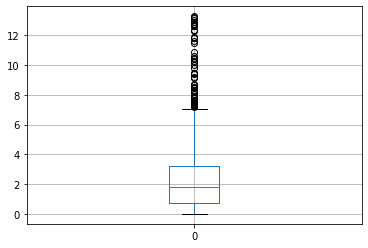

In [12]:
df = pd.DataFrame(np.array(error_list).reshape(-1))
df.plot.box(grid='True')

This plot seems like very similar to the boxplot found in part d. So, we can conclude that the approaches followed in part d and bonus part give more accurate results in terms of MAPE among all other approaches.  